## KNN Model for Speaker Gender Classification

In [2]:
from pyAudioAnalysis import audioTrainTest as aT
from pyAudioAnalysis import audioFeatureExtraction as aF
from pyAudioAnalysis import audioBasicIO
import numpy as np
import copy
from matplotlib import pyplot as plt 
from alibi.explainers import AnchorBaseBeam
from scipy.spatial import distance
#aT.fileClassification("data/speech_music_sample.wav", "data/knnMusicGenre3","knn")

In [3]:
model_name="data/knnSpeakerFemaleMale"
[classifier, MEAN, STD, classNames, mt_win, mt_step, st_win, st_step,compute_beat] = aT.load_model_knn(model_name)
print(compute_beat,classNames)

False ['Male', 'Female']


In [4]:
def extract_features(x :np.ndarray):
    [mt_features, s, _] = aF.mtFeatureExtraction(x, Fs, mt_win * Fs, mt_step * Fs, round(Fs * st_win), round(Fs * st_step))
    mt_features = mt_features.mean(axis=1)        # long term averaging of mid-term statistics
    if compute_beat:
        [beat, beatConf] = aF.beatExtraction(s, st_step)
        mt_features = np.append(mt_features, beat)
        mt_features = np.append(mt_features, beatConf)
    return (mt_features - MEAN) / STD 


def classify(self, test_sample):
    n_classes = np.unique(self.Y).shape[0]
    y_dist = (distance.cdist(self.X,test_sample,'euclidean')).T
    i_sort = np.argsort(y_dist,axis=1)
    P = np.zeros((test_sample.shape[0],n_classes))
    for j in range(len(test_sample)):
        for i in range(n_classes):
            P[j][i] = np.nonzero(self.Y[i_sort[j][0:self.k]] == i)[0].shape[0] / float(self.k)
    return (np.argmax(P,axis=1), P)

In [5]:
def predict_fn(x :np.ndarray):
    curFV = np.array([extract_features(y) for y in x])
    [Result, P] = classify(classifier, curFV)
    return Result

## Audio data for prediction

[0 1]
Male Female


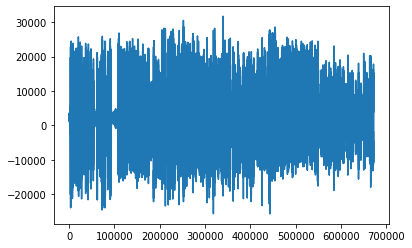

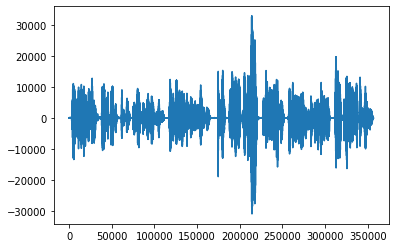

In [6]:
inputFile="data/diarizationExample.wav"
[Fs, audio] = audioBasicIO.readAudioFile(inputFile)
audio = audioBasicIO.stereo2mono(audio)

inputFile1="data/diarizationExample2.wav"
[Fs, audio1] = audioBasicIO.readAudioFile(inputFile1)
audio1 = audioBasicIO.stereo2mono(audio1)
# print(Fs,audio.ndim,audio.size)
# print(audio.max(),audio.min())
val = predict_fn(np.array([audio,audio1]))
print(val)
print(classNames[val[0]],classNames[val[1]])
plt.plot(audio)
plt.show()

plt.plot(audio1)
plt.show()

## Segmentation using diarization

In [7]:
from pyAudioAnalysis import audioSegmentation as aS
inputFile="data/diarizationExample.wav"
win_segment = aS.speakerDiarization(inputFile,0,mt_step=0.2)
# plt.plot(win_segment)
# plt.show()

/usr/local/lib/python3.7/dist-packages/sklearn/discriminant_analysis.py:466: ChangedBehaviorWarning: n_components cannot be larger than min(n_features, n_classes - 1). Using min(n_features, n_classes - 1) = min(26, 5 - 1) = 4 components.
  ChangedBehaviorWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/discriminant_analysis.py:472: FutureWarning: In version 0.23, setting n_components > min(n_features, n_classes - 1) will raise a ValueError. You should set n_components to None (default), or a value smaller or equal to min(n_features, n_classes - 1).
  warnings.warn(future_msg, FutureWarning)


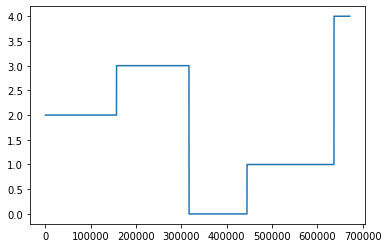

In [8]:
segments = np.zeros(audio.size)
for k in range(len(segments)):
    segments[k]=win_segment[int(k / (Fs*0.2))]
segments= segments.astype(int)    
plt.plot(segments)
plt.show()   

In [9]:
features = list(np.unique(segments))
n_features = len(features)
print(features)

[0, 1, 2, 3, 4]


In [10]:
true_label = predict_fn(np.array([audio]))[0]
print(true_label)

0


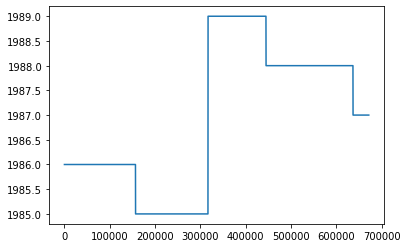

In [11]:
noise_audio = audio.copy()
for x in features:
    noise_audio[segments == x] = np.mean(audio[segments == x])
plt.plot(noise_audio)
plt.show()     

In [12]:
p_sample=0.5
def sample_fn(present: list, num_samples: int, compute_labels: bool = True):
            if not compute_labels:
                data = np.random.randint(0, 2, num_samples * n_features).reshape((num_samples, n_features))
                data[:, present] = 1  
                return np.array([]), data, np.array([])

            data = np.random.choice([0, 1], num_samples * n_features,
                                    p=[p_sample, 1 - p_sample]).reshape((num_samples, n_features))
            data[:, present] = 1  
            
            auds = []
            for row in data:
                temp = copy.deepcopy(audio)
                zeros = np.where(row == 0)[0]  
                mask = np.zeros(segments.shape).astype(bool)
                for z in zeros:
                    mask[segments == z] = True
                temp[mask] = noise_audio[mask]
                auds.append(temp)
            auds = np.array(auds)
            preds = predict_fn(auds)  

            labels = (preds == true_label).astype(int)
            raw_data = data
            return raw_data, data, labels

In [25]:
exp = AnchorBaseBeam.anchor_beam(sample_fn,batch_size=10,coverage_samples=1,desired_confidence=0.8)

In [26]:
exp

{'feature': [0],
 'mean': [1.0],
 'precision': [1.0],
 'coverage': [0.0],
 'examples': [{'covered': array([[1, 0, 1, 0, 1],
          [1, 1, 0, 1, 1],
          [1, 1, 1, 1, 1],
          [1, 0, 1, 0, 1],
          [1, 0, 1, 0, 0],
          [1, 0, 0, 0, 0],
          [1, 1, 0, 1, 0],
          [1, 0, 0, 0, 0],
          [1, 1, 0, 1, 0],
          [1, 1, 1, 0, 0]]), 'covered_true': array([[1, 0, 1, 0, 1],
          [1, 1, 0, 0, 0],
          [1, 1, 1, 1, 0],
          [1, 0, 0, 1, 1],
          [1, 1, 1, 0, 0],
          [1, 1, 0, 0, 1],
          [1, 0, 0, 1, 1],
          [1, 1, 0, 1, 1],
          [1, 0, 1, 0, 0],
          [1, 1, 1, 0, 1]]), 'covered_false': array([], shape=(0, 5), dtype=int64), 'uncovered_true': array([], dtype=float64), 'uncovered_false': array([], dtype=float64)}],
 'all_precision': 0,
 'num_preds': 100011}

In [28]:
print(exp['precision'],exp['feature'])
features

[1.0] [0]


[0, 1, 2, 3, 4]

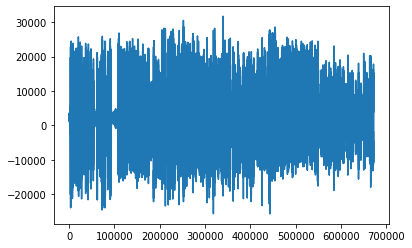

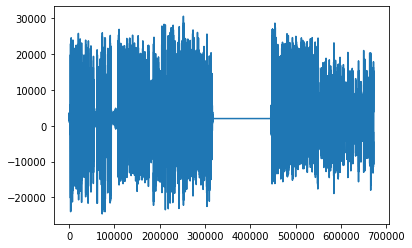

In [33]:
from scipy.io.wavfile import write
temp = copy.deepcopy(audio) 
mask = np.zeros(segments.shape).astype(bool)
for z in exp['feature']:
    mask[segments == z] = True
temp[mask] = noise_audio[mask]

write('result/explain.wav', Fs, temp)
plt.plot(audio)
plt.show() 

plt.plot(temp)
plt.show() 


In [32]:
from playsound import playsound

# Original

playsound('data/diarizationExample.wav')

# Explanation

playsound('result/explain.wav')